In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA

from torch_linregr import *

# Integrating CPHS Data and Code

## Load Data

In [2]:
import pickle

with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block1.pickle", 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, _, _, _, _, _, _ = pickle.load(handle)

#with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block2.pickle", 'rb') as handle:
#    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
#    refs_block2, _, _, _, emgs_block2, _, _, _, _, _, _ = pickle.load(handle)

In [3]:
keys = ['METACPHS_S106', 'METACPHS_S107', 'METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']
num_conds = 8
num_channels = 64
num_updates = 19
cphs_starting_update = 10
update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]

In [4]:
lambdaF = 0
lambdaD = 1e-3
lambdaE = 1e-6
lambdasFDE=[lambdaF, lambdaD, lambdaE]

In [5]:
print("Condition 1")
F1tens_full = torch.from_numpy(emgs_block1[keys[0]][0, :, :]).type(torch.float32)
PREF1tens_full = torch.from_numpy(refs_block1[keys[0]][0, :, :]).type(torch.float32)

print(f"EMG Input size: {F1tens_full.size()}")
print(f"2D Velocity Label size: {PREF1tens_full.size()}")

Condition 1
EMG Input size: torch.Size([20770, 64])
2D Velocity Label size: torch.Size([20770, 2])


## PyTorch Linear Regression With Full Dataset

In [6]:
num_updates = 19
starting_update = 0
normalize_emg = False
pca_channel_default = 64
PCA_comps = 64

total_epochs_FullData = 500

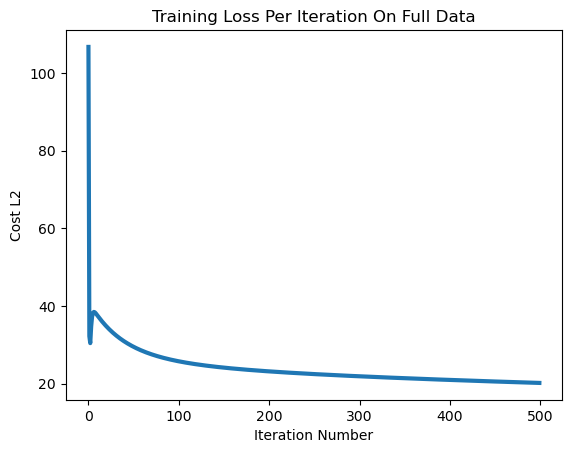

In [7]:
num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FullData.parameters(), lr=learning_rate)

trained_model_FullData, loss_log_FullData = full_train_linregr_updates(untrained_model_FullData, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=total_epochs_FullData, lambdasFDE=[lambdaF, lambdaD, lambdaE], stream_data_updates=False, use_full_input_data=True, starting_update=0)

plt.plot(range(len(loss_log_FullData)), loss_log_FullData, linewidth=3)
plt.title("Training Loss Per Iteration On Full Data")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Observe performance on first update only

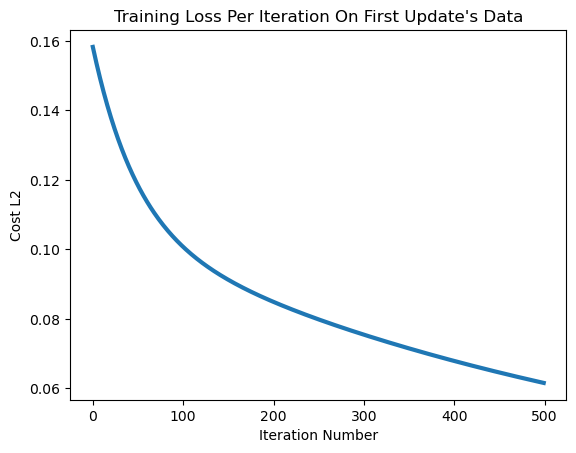

In [8]:
num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FirstUpdate = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FirstUpdate.parameters(), lr=learning_rate)

trained_model_FirstUpdate, loss_log_FirstUpdate = full_train_linregr_updates(untrained_model_FirstUpdate, F1tens_full[update_ix[0]:update_ix[1]], PREF1tens_full[update_ix[0]:update_ix[1]], learning_rate, lambdasFDE=[lambdaF, lambdaD, lambdaE], num_iters_per_update=total_epochs_FullData, stream_data_updates=False, use_full_input_data=True)

plt.plot(range(len(loss_log_FirstUpdate)), loss_log_FirstUpdate, linewidth=3)
plt.title("Training Loss Per Iteration On First Update's Data")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Use the same model as above but now train it on 2nd update's data

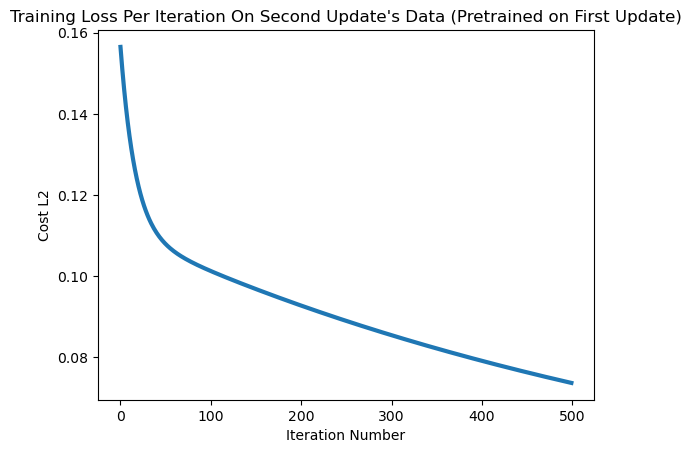

In [9]:
trained_model_SecondUpdate, loss_log_SecondUpdate = full_train_linregr_updates(untrained_model_FirstUpdate, F1tens_full[update_ix[1]:update_ix[2]], PREF1tens_full[update_ix[1]:update_ix[2]], learning_rate, num_iters_per_update=total_epochs_FullData, lambdasFDE=[lambdaF, lambdaD, lambdaE], stream_data_updates=False, use_full_input_data=True, starting_update=0)

plt.plot(range(len(loss_log_SecondUpdate)), loss_log_SecondUpdate, linewidth=3)
plt.title("Training Loss Per Iteration On Second Update's Data (Pretrained on First Update)")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Follow the above progression, plotting each successive update's training loss, using the previously trained model

In [10]:
num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
trained_model = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(trained_model.parameters(), lr=learning_rate)

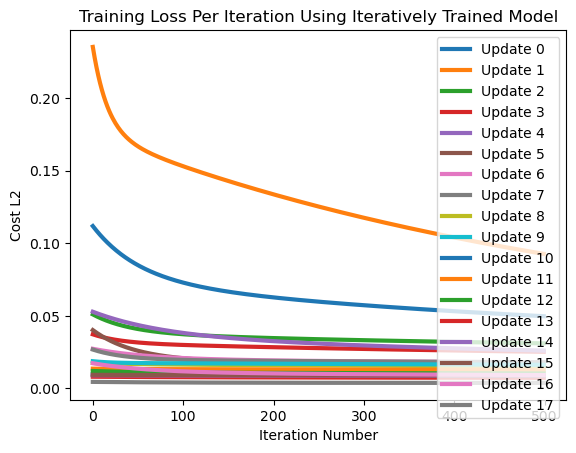

In [11]:
for update_num in range(18):
    trained_model, loss_log_tm = full_train_linregr_updates(trained_model, F1tens_full[update_ix[update_num]:update_ix[update_num+1]], PREF1tens_full[update_ix[update_num]:update_ix[update_num+1]], learning_rate, num_iters_per_update=total_epochs_FullData, stream_data_updates=False, lambdasFDE=[lambdaF, lambdaD, lambdaE], use_full_input_data=True)
    plt.plot(range(len(loss_log_tm)), loss_log_tm, linewidth=3, label=f"Update {update_num}")
    
plt.title("Training Loss Per Iteration Using Iteratively Trained Model")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.legend()
plt.show()

Looking at a fresh model trained initially on only the second to last model's data

Round 0 complete
Round 10 complete
Round 20 complete
Round 30 complete
Round 40 complete
Round 50 complete
Round 60 complete
Round 70 complete
Round 80 complete
Round 90 complete


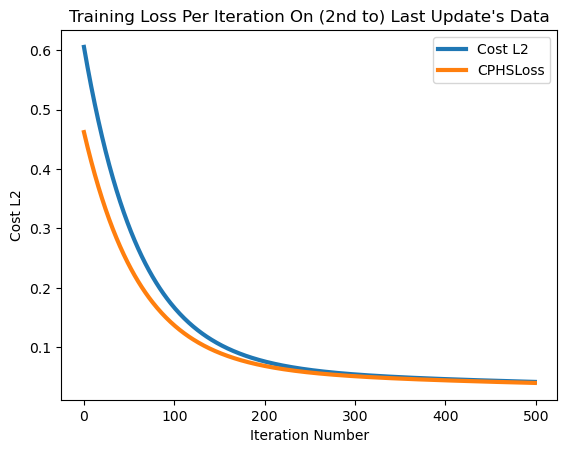

In [12]:
num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity
learning_rate = 0.0001

big_num_iters = 100
running_costl2_loss_log = torch.zeros(total_epochs_FullData)
running_CPHSLoss_loss_log = torch.zeros(total_epochs_FullData)

for i in range(big_num_iters):
    if i % 10 == 0:
        print(f"Round {i} complete")
    
    untrained_model_LastUpdate = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
    optimizer = torch.optim.SGD(untrained_model_LastUpdate.parameters(), lr=learning_rate)
    trained_model_LastUpdate, loss_log_LastUpdate = full_train_linregr_updates(untrained_model_LastUpdate, F1tens_full[update_ix[-3]:update_ix[-2]], PREF1tens_full[update_ix[-3]:update_ix[-2]], learning_rate, lambdasFDE=[lambdaF, lambdaD, lambdaE], num_iters_per_update=total_epochs_FullData, stream_data_updates=False, use_full_input_data=True, starting_update=0)
    running_costl2_loss_log += torch.tensor(loss_log_LastUpdate)

    untrained_model_LastUpdate_CPHSLoss = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
    optimizer = torch.optim.SGD(untrained_model_LastUpdate_CPHSLoss.parameters(), lr=learning_rate)
    trained_model_LastUpdate_CPHSLoss, loss_log_LastUpdate_CPHSLoss = full_train_linregr_updates(untrained_model_LastUpdate_CPHSLoss, F1tens_full[update_ix[-3]:update_ix[-2]], PREF1tens_full[update_ix[-3]:update_ix[-2]], learning_rate, num_iters_per_update=total_epochs_FullData, lambdasFDE=[lambdaF, lambdaD, lambdaE], stream_data_updates=False, use_full_input_data=True, starting_update=0)
    running_CPHSLoss_loss_log += torch.tensor(loss_log_LastUpdate_CPHSLoss)

plt.plot(range(len(running_costl2_loss_log)), running_costl2_loss_log/big_num_iters, linewidth=3, label='Cost L2')
plt.plot(range(len(running_CPHSLoss_loss_log)), running_CPHSLoss_loss_log/big_num_iters, linewidth=3, label='CPHSLoss')
plt.title("Training Loss Per Iteration On (2nd to) Last Update's Data")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.legend()
plt.show()

Needed to run and average the tensors since the training loss is not deterministic (assuming because of SGD optimizer?)

## PyTorch Linear Regression With Streamed Data

In [13]:
num_updates = 19
starting_update = 0
normalize_emg = False
pca_channel_default = 64
PCA_comps = 64

input_size = num_input_channels
output_size = 2  # 2D Velocity

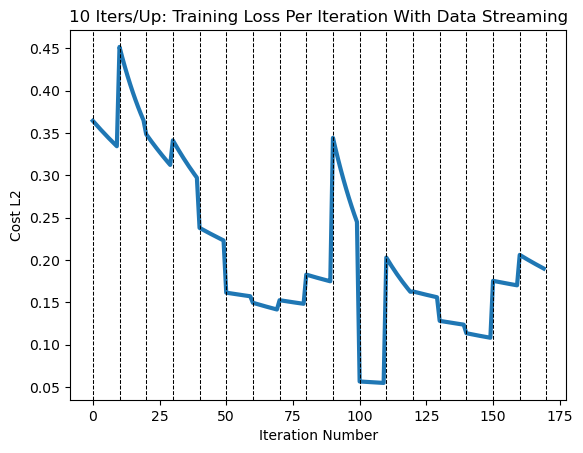

In [14]:
num_iters_per_update = 10

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_NoFL = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_NoFL.parameters(), lr=learning_rate)

trained_model_NoFL, loss_log_NoFL = full_train_linregr_updates(untrained_model_NoFL, F1tens_full, PREF1tens_full, learning_rate, lambdasFDE=[lambdaF, lambdaD, lambdaE], num_iters_per_update=num_iters_per_update, starting_update=0)

plt.plot(range(len(loss_log_NoFL)), loss_log_NoFL, linewidth=3)
plt.title("10 Iters/Up: Training Loss Per Iteration With Data Streaming")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

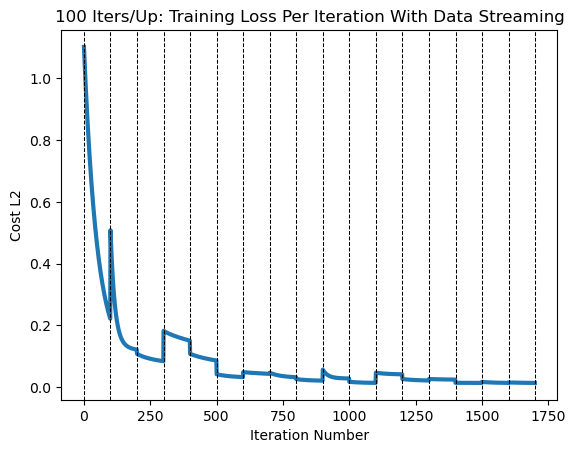

In [15]:
num_iters_per_update = 100

num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_NoFL = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_NoFL.parameters(), lr=learning_rate)

trained_model_NoFL, loss_log_NoFL = full_train_linregr_updates(untrained_model_NoFL, F1tens_full, PREF1tens_full, learning_rate, lambdasFDE=[lambdaF, lambdaD, lambdaE], num_iters_per_update=num_iters_per_update, starting_update=0)

plt.plot(range(len(loss_log_NoFL)), loss_log_NoFL, linewidth=3)
plt.title("100 Iters/Up: Training Loss Per Iteration With Data Streaming")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

## Redo but with FL Data Processing Turned On

In [16]:
# PARAMS
num_updates = 9
starting_update = 10
normalize_emg = True
pca_channel_default = 64
PCA_comps = 7

# BUILD MODEL
num_input_channels = PCA_comps 
input_size = num_input_channels
# ^ IRL I'm not sure we are guaranteed to get equalength trials
#  Thus may be better to do every time point individually? Not sure
output_size = 2  # 2D Velocity
learning_rate = 0.0001

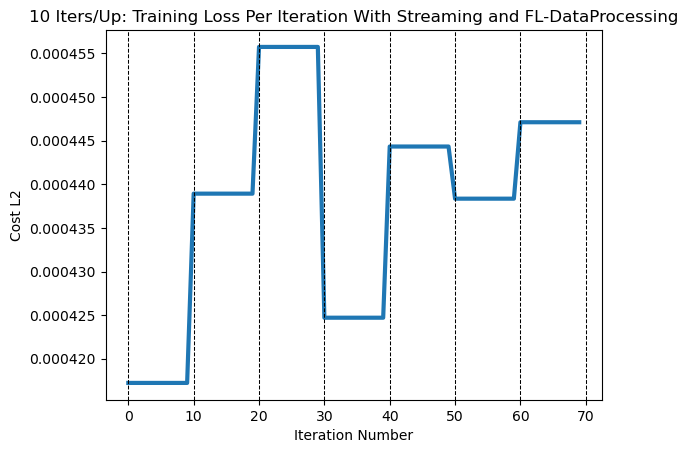

In [18]:
num_iters_per_update=10

num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FLDP = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP.parameters(), lr=learning_rate)

trained_model_FLDP, loss_log_FLDP = full_train_linregr_updates(untrained_model_FLDP, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=num_iters_per_update, starting_update=10, lambdasFDE=[lambdaF, lambdaD, lambdaE], normalize_emg=True, PCA_comps=7, loss_log=[])

plt.plot(range(len(loss_log_FLDP)), loss_log_FLDP, linewidth=3)
plt.title("10 Iters/Up: Training Loss Per Iteration With Streaming and FL-DataProcessing")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

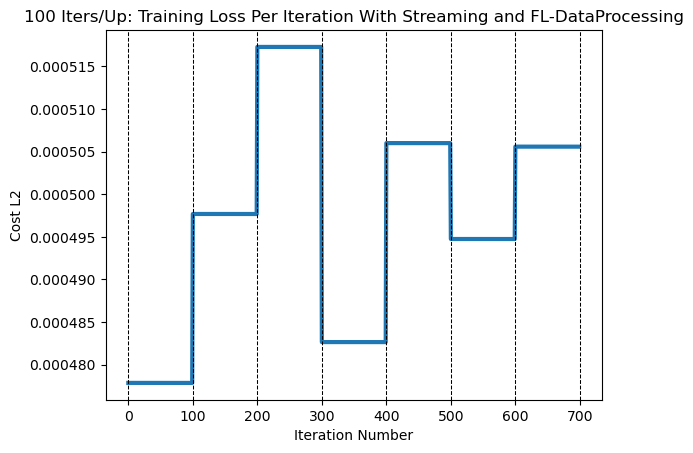

In [19]:
num_iters_per_update=100

num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FLDP100 = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP100.parameters(), lr=learning_rate)

trained_model_FLDP100, loss_log_FLDP100 = full_train_linregr_updates(untrained_model_FLDP100, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=num_iters_per_update, lambdasFDE=[lambdaF, lambdaD, lambdaE], starting_update=10, normalize_emg=True, PCA_comps=7, loss_log=[])

plt.plot(range(len(loss_log_FLDP100)), loss_log_FLDP100, linewidth=3)
plt.title("100 Iters/Up: Training Loss Per Iteration With Streaming and FL-DataProcessing")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Investigating why the above code is trash with static cost functions

Norm EMG but no PCA

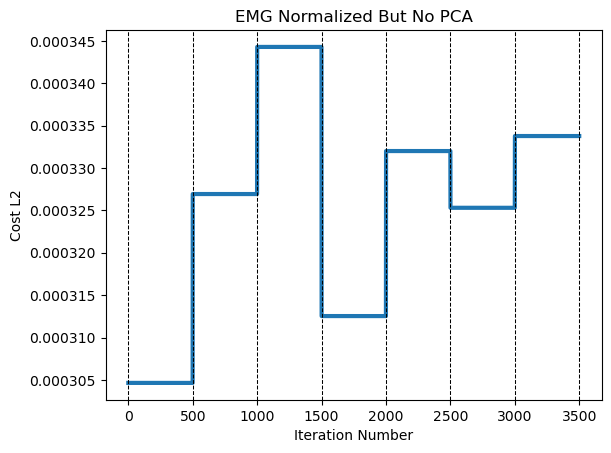

In [20]:
# PARAMS
num_updates = 9
starting_update = 10
normalize_emg = True
pca_channel_default = 64
PCA_comps = 64

#######################################################################

num_iters_per_update=500

num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FLDP100 = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP100.parameters(), lr=learning_rate)

trained_model_FLDP100, loss_log_FLDP100 = full_train_linregr_updates(untrained_model_FLDP100, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=num_iters_per_update, lambdasFDE=[lambdaF, lambdaD, lambdaE], starting_update=10, normalize_emg=normalize_emg, PCA_comps=PCA_comps, loss_log=[])

plt.plot(range(len(loss_log_FLDP100)), loss_log_FLDP100, linewidth=3)
plt.title("EMG Normalized But No PCA")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Don't Normalize EMG but do use PCA

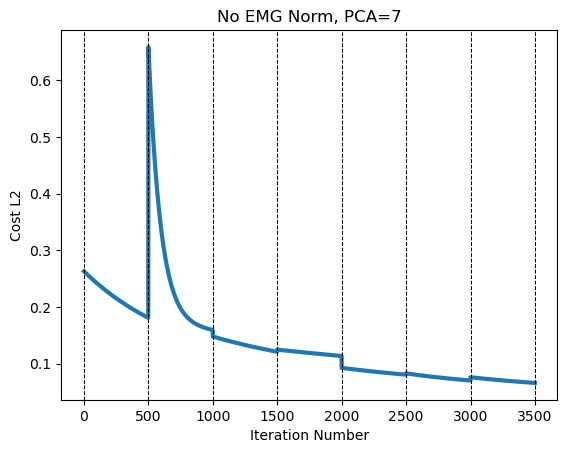

In [21]:
# PARAMS
num_updates = 9
starting_update = 10
normalize_emg = False
pca_channel_default = 64
PCA_comps = 7

#######################################################################

num_iters_per_update=500

num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FLDP100 = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP100.parameters(), lr=learning_rate)

trained_model_FLDP100, loss_log_FLDP100 = full_train_linregr_updates(untrained_model_FLDP100, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=num_iters_per_update, starting_update=10, lambdasFDE=[lambdaF, lambdaD, lambdaE], normalize_emg=normalize_emg, PCA_comps=PCA_comps, loss_log=[])

plt.plot(range(len(loss_log_FLDP100)), loss_log_FLDP100, linewidth=3)
plt.title("No EMG Norm, PCA=7")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Why does normalizing the EMG break everything?
> Assuming this means that the norm(F) is still driving everything in the cost function...

# Validation with SKLearn
> Note that using Least Squares, we can solve for the closed-form solution (e.g. don't need to iteratively solve via gradient descent).  However, for the federated case, we can't just use the one-shot closed-form solution since averaging local solutions can perform arbitrarily poorly (...); likewise, each client does not have the full dataset (e.g. all the data in the network) and thus will not solve for the overall solution (only their local solution, which as discussed above, is a poor global solution).

In [22]:
import sklearn.linear_model

total_num_samples = F1tens_full.size()[0]
training_split = 0.7
split_index = int(np.ceil(total_num_samples*training_split))

x_train = F1tens_full[:split_index, :]
y_train = PREF1tens_full[:split_index, :]

linr = sklearn.linear_model.LinearRegression()
#linr.fit(torch.transpose(F1tens_full,0,1), torch.transpose(PREF1tens_full,0,1))
linr.fit(x_train, y_train)

LinearRegression()

In [23]:
x_segment = F1tens_full[split_index:, :]
y_segment = PREF1tens_full[split_index:, :]

criterion = torch.nn.MSELoss()

print(f"Score Loss: {linr.score(x_segment, y_segment)}")
print(f"Criterion Loss: {criterion(torch.tensor(linr.predict(x_segment)), y_segment)}")
print("---------------------------------------------")
print("Prediction:")
print(f"b_pred = {linr.intercept_.shape}")
print(linr.intercept_)
print()
print(f"w_pred = {linr.coef_.shape}")
print(linr.coef_)

Score Loss: -0.045655846284475055
Criterion Loss: 383.3099365234375
---------------------------------------------
Prediction:
b_pred = (2,)
[-1.8256361   0.15341043]

w_pred = (2, 64)
[[-0.00587902 -0.1584281   0.19627433 -0.04266059 -0.21424386 -0.1544629
   0.70050985  0.31700796  0.5889256  -0.14915393  0.19597588  0.01359087
  -0.0428264   0.11913121 -0.22523853 -0.28694415 -0.06327245 -0.2411712
  -0.15157585 -0.10179265 -0.07783086  0.24455187  0.17596787  0.28622887
  -0.16191706  0.00424507 -0.24586949 -0.41467413  0.06515794 -0.19231932
  -0.17085227 -0.7291353  -0.6091871   0.23037383  0.04621361 -0.25727147
   0.7605858  -0.5778158  -0.23404795  0.24167557 -0.09022208 -0.88054115
   0.71510077  0.40908486  0.12999162 -0.02063707  0.32553715  0.17085972
   0.09551223 -0.05164771  0.09615561 -0.16781515  0.18379697 -0.1641163
  -0.268238    0.04853393 -0.39018238  0.38417014  0.17175156  2.04209
   0.32894707 -0.49231118  0.0446486  -0.47521046]
 [-0.02817893  0.03087825 -0.06